# Project Summary: Investigating Imbalanced Data in ML Models

In this project, I aim to investigate the impact of imbalanced data on machine learning model performance and devise effective strategies to mitigate this issue. Specifically, I will explore the efficacy of simple down-sampling, SMOTE (Synthetic Minority Over-sampling Technique), and ADASYN (Adaptive Synthetic Sampling) methods. The project will focus on a dataset concerning customer churn. The key steps involved are outlined below:

1. **Dataset Import:** Begin by importing the imbalanced dataset of customer churn.

2. **Data Discovery and EDA:** Conduct thorough data discovery and exploratory data analysis (EDA) to gain insights into the dataset's features, their trends, and their influence on the target value.

3. **Model Training - Logistic Regression:**
   - Train a logistic regression model on the dataset under three different scenarios:
     1. Training on the imbalanced data to establish baseline performance.
     2. Training on data after simple down-sampling, SMOTE over-sampling, and ADASYN synthesis to compare results.
4. **XGBoost:**
 Finally train the best-performing scenario from the previous step on a powerful XGBoost classifier to push the performance limits on this dataset.

By following this structured approach, I aim to uncover valuable insights into handling imbalanced data and optimizing machine learning models for improved performance.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/it-customer-churn/IT_customer_churn.csv


# Import libraries and packages

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data upload

In [3]:
df = pd.read_csv('/kaggle/input/it-customer-churn/IT_customer_churn.csv')
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6512,Male,0,No,No,11,Yes,No,DSL,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Electronic check,60.90,688.5,No
86,Female,0,Yes,No,35,Yes,No,DSL,Yes,No,No,No,Yes,No,One year,Yes,Bank transfer (automatic),62.15,2215.45,No
1518,Female,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.55,96.1,No
3943,Male,1,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.00,44,No
1430,Female,0,No,No,23,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),24.80,615.35,No


# Data discovery

In [4]:
df.shape

(7043, 20)

In [5]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [8]:
# Dataset balancing status
100*df.Churn.value_counts(normalize=True)

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

***There seems to be a problem with the "TotalCharges" feature, which is supposed to be a float number while it is an object***

In [9]:
df.TotalCharges=df['TotalCharges'].str.strip()
pd.to_numeric(df.TotalCharges,errors='coerce').isnull().sum()

11

***We have to first convert the "TotalCharges" to numeric data and then drop the null values***

In [10]:
df['TotalCharges']= pd.to_numeric(df.TotalCharges,errors='coerce')
df.dropna(subset=['TotalCharges'],axis=0,inplace=True)
df.shape

(7032, 20)

In [11]:
def list_unique_values(df):
    obj_col = df.select_dtypes(include='object').columns
    for col in obj_col:
        print(f"The categories of column {col}: {df[col].unique()}")


In [12]:
list_unique_values(df)

The categories of column gender: ['Female' 'Male']
The categories of column Partner: ['Yes' 'No']
The categories of column Dependents: ['No' 'Yes']
The categories of column PhoneService: ['No' 'Yes']
The categories of column MultipleLines: ['No phone service' 'No' 'Yes']
The categories of column InternetService: ['DSL' 'Fiber optic' 'No']
The categories of column OnlineSecurity: ['No' 'Yes' 'No internet service']
The categories of column OnlineBackup: ['Yes' 'No' 'No internet service']
The categories of column DeviceProtection: ['No' 'Yes' 'No internet service']
The categories of column TechSupport: ['No' 'Yes' 'No internet service']
The categories of column StreamingTV: ['No' 'Yes' 'No internet service']
The categories of column StreamingMovies: ['No' 'Yes' 'No internet service']
The categories of column Contract: ['Month-to-month' 'One year' 'Two year']
The categories of column PaperlessBilling: ['Yes' 'No']
The categories of column PaymentMethod: ['Electronic check' 'Mailed check' '

***It seems that some of the categories in the features above are redundent categries and can be merged into other categories***

In [13]:
redundant_cat_cols = ['MultipleLines',
                      'OnlineSecurity',
                      'OnlineBackup',
                      'DeviceProtection',
                      'TechSupport',
                      'StreamingTV',
                      'StreamingMovies']

for col in redundant_cat_cols:
    df[col] = df[col].where(df[col].isin(['Yes', 'No']), 'No')


In [14]:
list_unique_values(df)

The categories of column gender: ['Female' 'Male']
The categories of column Partner: ['Yes' 'No']
The categories of column Dependents: ['No' 'Yes']
The categories of column PhoneService: ['No' 'Yes']
The categories of column MultipleLines: ['No' 'Yes']
The categories of column InternetService: ['DSL' 'Fiber optic' 'No']
The categories of column OnlineSecurity: ['No' 'Yes']
The categories of column OnlineBackup: ['Yes' 'No']
The categories of column DeviceProtection: ['No' 'Yes']
The categories of column TechSupport: ['No' 'Yes']
The categories of column StreamingTV: ['No' 'Yes']
The categories of column StreamingMovies: ['No' 'Yes']
The categories of column Contract: ['Month-to-month' 'One year' 'Two year']
The categories of column PaperlessBilling: ['Yes' 'No']
The categories of column PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
The categories of column Churn: ['No' 'Yes']


In [15]:
100*df['SeniorCitizen'].value_counts(normalize=True)

SeniorCitizen
0    83.759954
1    16.240046
Name: proportion, dtype: float64

# EDA and Visualization

In [16]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [17]:
df[df['Churn'] == 'Yes'].groupby(by='StreamingMovies')['Churn'].count()

StreamingMovies
No     1051
Yes     818
Name: Churn, dtype: int64

In [18]:
df[df['Churn'] == 'Yes'].groupby(by='StreamingTV')['Churn'].count()

StreamingTV
No     1055
Yes     814
Name: Churn, dtype: int64

In [19]:
df[df['Churn'] == 'Yes'].groupby(by='TechSupport')['Churn'].count()

TechSupport
No     1559
Yes     310
Name: Churn, dtype: int64

***The effect of followings on the churn will be investigated through visualization and statistical tests:***
- Gender
- Whether or not any dependents
- Tenure
- Type of contract
- Payment method
- Total charges
- Monthly charges

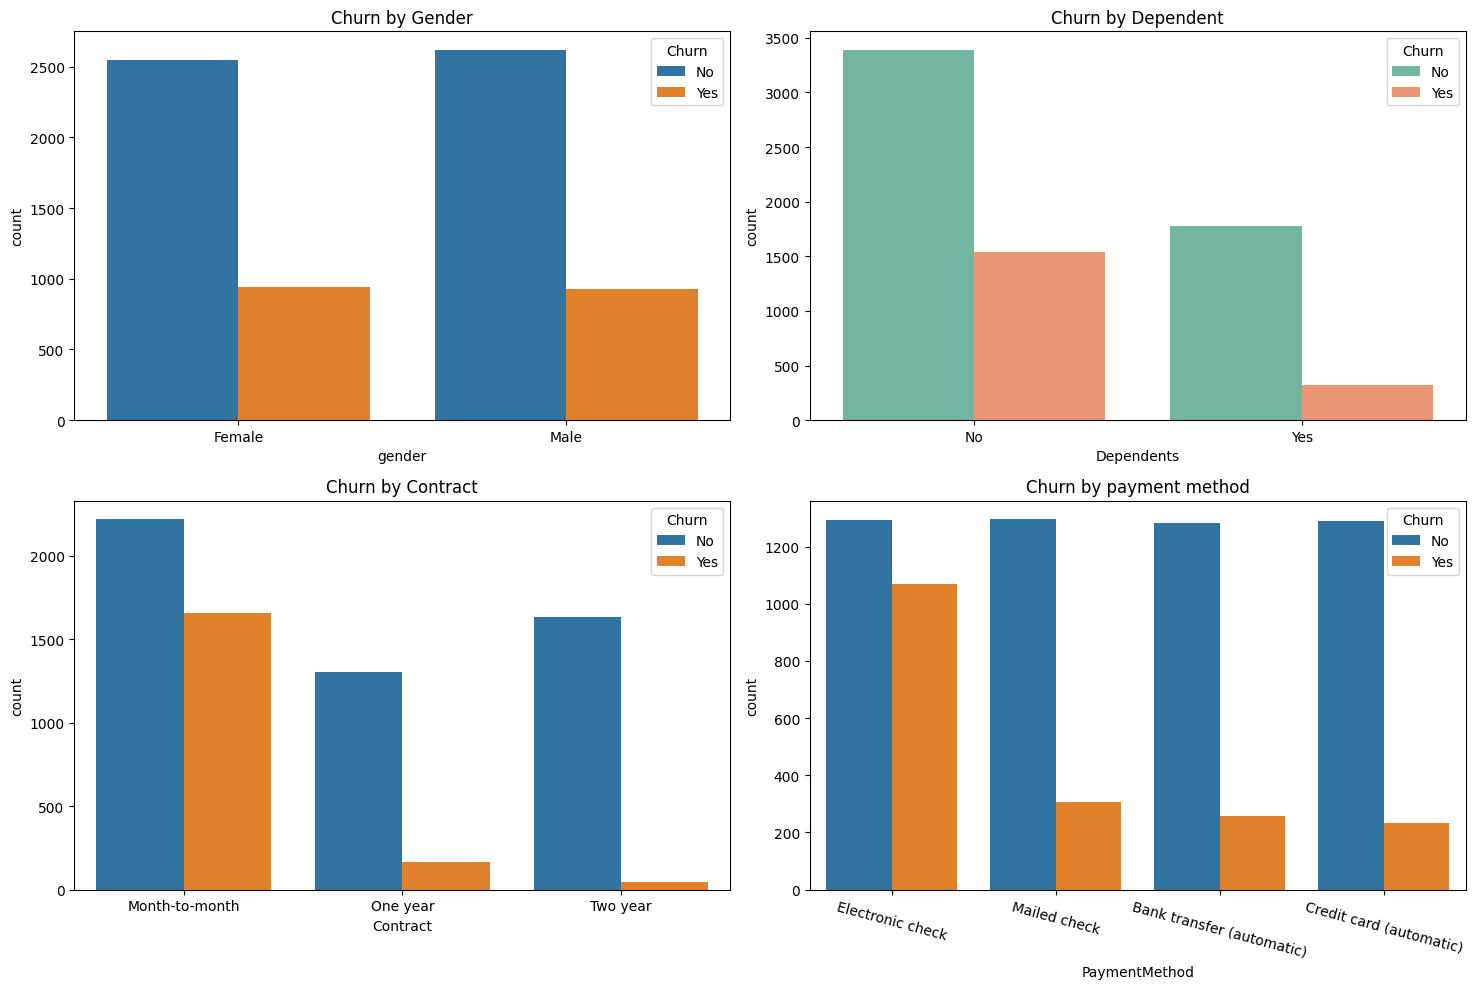

In [20]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot countplot for 'gender' in the first subplot
sns.countplot(data=df, x='gender', hue='Churn', ax=axes[0,0])
axes[0,0].set_title('Churn by Gender')

# Plot countplot for 'dependent' in the second subplot
sns.countplot(data=df, x='Dependents', hue='Churn', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Churn by Dependent')
# Plot countplot for 'contract' in the third subplot
sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[1,0])
axes[1,0].set_title('Churn by Contract')
# Plot countplot for 'payment method' in the third subplot
sns.countplot(data=df, x='PaymentMethod', hue='Churn', ax=axes[1,1])
axes[1,1].set_title('Churn by payment method')
axes[1, 1].tick_params(axis='x', rotation=-15)  # Rotate xticks by 45 degrees
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


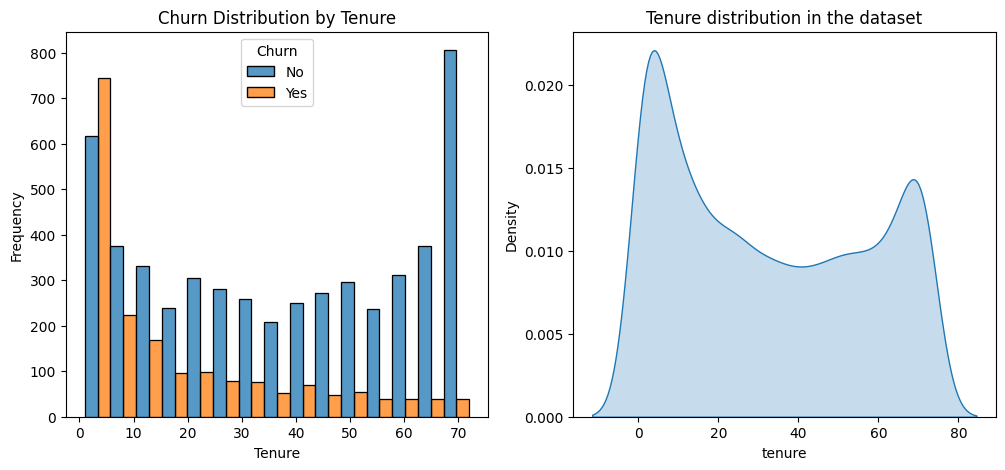

In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.histplot(data=df,x='tenure',hue='Churn', multiple='dodge',ax=axes[0])
axes[0].set_xlabel('Tenure')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Churn Distribution by Tenure')
sns.kdeplot(data=df,x='tenure',ax=axes[1],fill=True)
axes[1].set_title('Tenure distribution in the dataset')
plt.show()

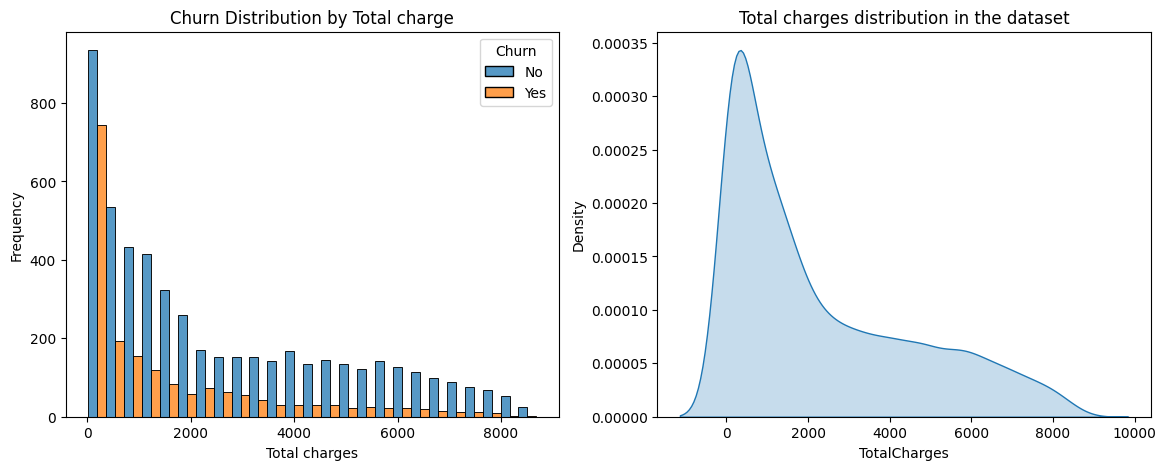

In [22]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
sns.histplot(data=df,x='TotalCharges',hue='Churn', multiple='dodge',ax=axes[0])
axes[0].set_xlabel('Total charges')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Churn Distribution by Total charge')
sns.kdeplot(data=df,x='TotalCharges',ax=axes[1],fill=True)
axes[1].set_title('Total charges distribution in the dataset')
plt.show()

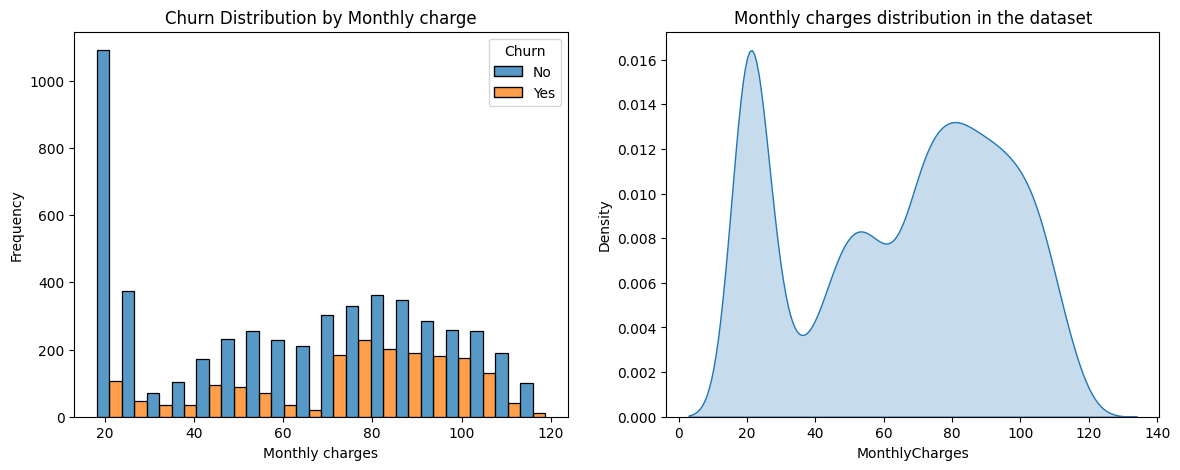

In [23]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
sns.histplot(data=df,x='MonthlyCharges',hue='Churn', multiple='dodge',ax=axes[0])
axes[0].set_xlabel('Monthly charges')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Churn Distribution by Monthly charge')
sns.kdeplot(data=df,x='MonthlyCharges',ax=axes[1],fill=True)
axes[1].set_title('Monthly charges distribution in the dataset')
plt.show()

### EDA takeaways:
- More than 80% of those who churned were ***not*** senior citizens.
- Gender appears to have almost no influence on the churn in this dataset.
- People who have no dependents are more prone to churn compared to people with dependents.
- The type of contract greatly influences the tendency of people to churn. Monthly contracts have the highest risk of churn.
- There is a significantly higher number of customers who churn with the electronic check payment method compared to other methods.
-Customers using automatic payment methods (bank transfer and credit card) tend to have lower churn rates. This could be due to the convenience and reliability of automatic payments, which might contribute to higher customer satisfaction and retention. While, the high churn rate for electronic checks could indicate issues with this payment method, such as perceived inconvenience, higher fees, or association with more transient customers.
- Total charges is heavily skewed to the left. This feature may lead to bias in training and needs to be normalized by either scaling or log transformation
-As monthly charges increase, the churn rate appears to increase as well. This suggests that customers with higher monthly payments are more likely to leave, possibly due to perceiving the service as less valuable or finding better alternatives.
- The binomial distribution of monthly charges can be handled by binning the charges of this 
feature for non-tree based models.
- Not having services such as  streaming packages and tech support may increase the tendency of people to churn.


# Model training: Logistic regression

### Import packages and libraries

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.metrics import classification_report,accuracy_score

from sklearn.model_selection import RandomizedSearchCV



#### Before training:
- Change the target value from binary categories to binary values
- Drop gender

In [25]:
df['Churn']=df['Churn'].map({'Yes':1,'No':0})
df.drop('gender',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7032 non-null   int64  
 1   Partner           7032 non-null   object 
 2   Dependents        7032 non-null   object 
 3   tenure            7032 non-null   int64  
 4   PhoneService      7032 non-null   object 
 5   MultipleLines     7032 non-null   object 
 6   InternetService   7032 non-null   object 
 7   OnlineSecurity    7032 non-null   object 
 8   OnlineBackup      7032 non-null   object 
 9   DeviceProtection  7032 non-null   object 
 10  TechSupport       7032 non-null   object 
 11  StreamingTV       7032 non-null   object 
 12  StreamingMovies   7032 non-null   object 
 13  Contract          7032 non-null   object 
 14  PaperlessBilling  7032 non-null   object 
 15  PaymentMethod     7032 non-null   object 
 16  MonthlyCharges    7032 non-null   float64
 17  

In [26]:
df.shape

(7032, 19)

# Model training: Logistic regression

In [27]:
train_set,val_set = train_test_split(df,test_size=0.3,random_state=12,stratify=df['Churn'])
val_set,test_set = train_test_split(val_set,test_size=0.1,random_state=12,stratify=val_set['Churn'])

In [28]:
train_set.shape, val_set.shape, test_set.shape

((4922, 19), (1899, 19), (211, 19))

In [29]:
X_train = train_set.drop('Churn',axis=1)
y_train= train_set.Churn
X_val = val_set.drop('Churn',axis=1)
y_val = val_set.Churn
X_test = test_set.drop('Churn',axis=1)
y_test = test_set.Churn

### Preprocessing

In [30]:
ohe= OneHotEncoder(handle_unknown='ignore',drop='first')
scaler = MinMaxScaler()
obj_col = df.select_dtypes(include='object').columns
num_col=['tenure','MonthlyCharges','TotalCharges']
ct = make_column_transformer((ohe,obj_col),(scaler,num_col),remainder='passthrough')

### Training

In [31]:
lr_pipe=Pipeline(steps=[
    ('prep',ct),('tr',LogisticRegression(random_state=0))
])
lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('tr', LogisticRegression(random_state=0))])

In [32]:
def training_report(model):
    y_pred = model.predict(X_train)
    train_acc = accuracy_score(y_pred,y_train)
    val_acc = model.score(X_val,y_val)
    y_pred_val = model.predict(X_val)
    cl_rep = classification_report(y_val,y_pred_val)
    print(f'Training Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {val_acc:.3f}')
    print(cl_rep)

In [33]:
training_report(lr_pipe)

Training Accuracy: 0.808
Validation Accuracy: 0.803
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1394
           1       0.66      0.54      0.59       505

    accuracy                           0.80      1899
   macro avg       0.75      0.72      0.73      1899
weighted avg       0.79      0.80      0.80      1899



## Down-sampling

In [34]:
count_class_0,count_class_1=df['Churn'].value_counts()
print(count_class_0)
print(count_class_1)

5163
1869


In [35]:
df_class_0=df[df['Churn']==0]
df_class_1=df[df['Churn']==1]
df_class_0 =df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0,df_class_1],axis=0)
print('Downsmapled dataframe:')
df_under['Churn'].value_counts()

Downsmapled dataframe:


Churn
0    1869
1    1869
Name: count, dtype: int64

In [36]:
train_set,val_set = train_test_split(df_under,test_size=0.3,random_state=12,stratify=df_under['Churn'])
val_set,test_set = train_test_split(val_set,test_size=0.1,random_state=12,stratify=val_set['Churn'])

In [37]:
X_train = train_set.drop('Churn',axis=1)
y_train= train_set.Churn
X_val = val_set.drop('Churn',axis=1)
y_val = val_set.Churn
X_test = test_set.drop('Churn',axis=1)
y_test = test_set.Churn

In [38]:
lr_pipe.fit(X_train,y_train)
training_report(lr_pipe)

Training Accuracy: 0.769
Validation Accuracy: 0.749
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       505
           1       0.73      0.80      0.76       504

    accuracy                           0.75      1009
   macro avg       0.75      0.75      0.75      1009
weighted avg       0.75      0.75      0.75      1009



## Over-sampling:SMOTE

In [39]:
X = df.drop('Churn',axis=1)
y=df.Churn
smt=SMOTE(sampling_strategy='auto',random_state=5)
X_transformed=ct.fit_transform(X,y)
X_res,y_res=smt.fit_resample(X_transformed,y)
y_res.value_counts()

Churn
0    5163
1    5163
Name: count, dtype: int64

In [40]:
X_train,X_val,y_train,y_val=train_test_split(X_res,y_res,test_size=0.3,random_state=12,stratify=y_res)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=0.1,random_state=12,stratify=y_val)

In [41]:
lr=LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
training_report(lr)

Training Accuracy: 0.777
Validation Accuracy: 0.765
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1394
           1       0.74      0.81      0.77      1394

    accuracy                           0.76      2788
   macro avg       0.77      0.76      0.76      2788
weighted avg       0.77      0.76      0.76      2788



## Over_sampling:ADASYN

In [42]:
X = df.drop('Churn',axis=1)
y=df.Churn
smt=ADASYN(sampling_strategy='auto',random_state=5)
X_transformed=ct.fit_transform(X,y)
X_res,y_res=smt.fit_resample(X_transformed,y)
y_res.value_counts()

Churn
0    5163
1    5040
Name: count, dtype: int64

In [43]:
X_train,X_val,y_train,y_val=train_test_split(X_res,y_res,test_size=0.3,random_state=12,stratify=y_res)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=0.1,random_state=12,stratify=y_val)

In [44]:
lr.fit(X_train,y_train)
training_report(lr)

Training Accuracy: 0.752
Validation Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1394
           1       0.71      0.79      0.75      1360

    accuracy                           0.73      2754
   macro avg       0.74      0.74      0.73      2754
weighted avg       0.74      0.73      0.73      2754



# Model training: XGBoost

In [45]:
X = df.drop('Churn',axis=1)
y=df.Churn
smt=SMOTE(sampling_strategy='auto',random_state=5)
X_transformed=ct.fit_transform(X,y)
X_res,y_res=smt.fit_resample(X_transformed,y)
X_train,X_val,y_train,y_val=train_test_split(X_res,y_res,test_size=0.3,random_state=12,stratify=y_res)
X_val,X_test,y_val,y_test=train_test_split(X_val,y_val,test_size=0.1,random_state=12,stratify=y_val)
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
training_report(xgb)

Training Accuracy: 0.947
Validation Accuracy: 0.835
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1394
           1       0.84      0.83      0.83      1394

    accuracy                           0.84      2788
   macro avg       0.84      0.84      0.84      2788
weighted avg       0.84      0.84      0.84      2788



# XGBoost fine tuning

In [46]:
def tuner_function(model):
    tuning_params={
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
    }
    scoring = {'accuracy', 'precision', 'recall', 'f1'}
    tuned_model=RandomizedSearchCV(model,param_distributions=tuning_params,scoring=scoring,cv=5,refit='f1')
    tuned_model.fit(X_train,y_train)
    print('Tuned model best parameters: {}'.format(tuned_model.best_params_))
    print('Tuned model best score: ',"%0.2f"%tuned_model.best_score_)
   
    training_report(tuned_model)
    return tuned_model
   

In [47]:
final_model=tuner_function(xgb)

Tuned model best parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Tuned model best score:  0.85
Training Accuracy: 0.877
Validation Accuracy: 0.834
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1394
           1       0.82      0.85      0.83      1394

    accuracy                           0.83      2788
   macro avg       0.83      0.83      0.83      2788
weighted avg       0.83      0.83      0.83      2788



# Saving the final model

In [48]:
import os
import pickle
file_name='final_model.pkl'
directory='/kaggle/working/'
file_path=os.path.join(directory,file_name)
with open(file_path, 'wb') as file:
     pickle.dump(final_model, file)
print(f'Model saved to {file_path}')

Model saved to /kaggle/working/final_model.pkl


# Model test: XGBoost

In [49]:
def test_report(model):
    test_acc = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    cl_rep = classification_report(y_test,y_pred)
    print(f'Test Accuracy: {test_acc:.3f}')
    print(cl_rep)

In [50]:
test_report(final_model)

Test Accuracy: 0.838
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       155
           1       0.82      0.85      0.84       155

    accuracy                           0.84       310
   macro avg       0.84      0.84      0.84       310
weighted avg       0.84      0.84      0.84       310



# Takeaways
- An imbalanced (biased) dataset was trained with and without synthetic oversampling methods, such as SMOTE (Synthetic Minority Over-sampling Technique) and ADASYN (Adaptive Synthetic Sampling Approach). Despite the significant difference in F1 scores for the binary classes at the beginning of training, the final F1 scores for both classes reached a maximum of 84%.
- One of the most effective methods for training an imbalanced (biased) dataset to improve both accuracy and generalization of the base model is using synthetic oversampling methods. These methods create synthetic samples from the minority class to balance the class distribution and mitigate the bias.
- **SMOTE** works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space, and drawing a new sample at a point along that line. This approach helps to create more general decision boundaries.
- **ADASYN** extends SMOTE by adapting the number of synthetic samples generated for each minority class example based on the learning difficulty. It focuses on those examples that are harder to learn, potentially improving model robustness.
- Although **ADASYN** appears to be a more advanced method compared to **SMOTE** due to its adaptive nature, there is no standard to prefer one over the other for different data structures. The choice between SMOTE and ADASYN should be based on empirical performance evaluation on the specific dataset being used.
- Both methods help in reducing overfitting by generating more varied synthetic samples, which can lead to better model generalization and improved performance metrics like F1 score, precision, and recall.

